# EDA of climate data
Belonging Repository: https://github.com/mic1899/earth_surface_temperature/tree/dev_main

Belonging Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


In [157]:
# Loading the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import plotly.express as px
from math import sqrt
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
from scipy import signal
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

%matplotlib inline

# Defining some general plot settings
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 200

In [2]:
# Class for colored terminal outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   ITALIC = '\033[3m'

print(color.BLUE + "Hier kommt ein Text" + color.END)

Hier kommt ein Text


In [36]:
# Defining the file names and path
PATH = "/home/rapunzel/home/projects/earth_surface_temperature/data/"
shorts = ["city", "country", "majorcity", "global", "state"]
datasets = dict(zip(shorts,os.listdir(PATH)))
# loading the different data sets
i = shorts[0]
df = pd.read_csv(PATH+datasets[i], delimiter=',')
df.name = i



In [185]:
datasets

{'city': 'GlobalLandTemperaturesByCity.csv',
 'country': 'GlobalLandTemperaturesByCountry.csv',
 'majorcity': 'GlobalLandTemperaturesByMajorCity.csv',
 'global': 'ChampagneSales.csv',
 'state': 'GlobalTemperatures.csv'}

In [174]:
df.query("City == 'Zurich'").head(10)
#d.to_datetime(df['dt']).toordinal()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day,dayofyear,trend_mean
date,,,,,,,,,,,,
1743-11-01,1743-11-01,3.544000,1.764,Zurich,Switzerland,47.42N,8.29E,1743,11,1,305,NaN
1743-12-01,1743-12-01,7.094947,NaN,Zurich,Switzerland,47.42N,8.29E,1743,12,1,335,NaN
1744-01-01,1744-01-01,6.634026,NaN,Zurich,Switzerland,47.42N,8.29E,1744,1,1,1,NaN
1744-02-01,1744-02-01,6.173105,NaN,Zurich,Switzerland,47.42N,8.29E,1744,2,1,32,NaN
1744-03-01,1744-03-01,5.741921,NaN,Zurich,Switzerland,47.42N,8.29E,1744,3,1,61,NaN
1744-04-01,1744-04-01,7.459000,2.243,Zurich,Switzerland,47.42N,8.29E,1744,4,1,92,NaN
1744-05-01,1744-05-01,9.890000,1.604,Zurich,Switzerland,47.42N,8.29E,1744,5,1,122,NaN
1744-06-01,1744-06-01,13.169000,1.574,Zurich,Switzerland,47.42N,8.29E,1744,6,1,153,NaN
1744-07-01,1744-07-01,14.980000,1.676,Zurich,Switzerland,47.42N,8.29E,1744,7,1,183,NaN


In [59]:
def time_conv(df):  # Expects a dataframe for only one city
    # Convert timestamp to datetime object
    # Extract additional features from timestamp column

    # Test for gaps in timeline
    #   q = df.query('City == "Zurich"').index.max().to_period('M') -  df.query('City == "Zurich"').index.min().to_period('M')
    # if q.n + 1 == len(df[df.City == "Zurich"]):
         

    df = df.assign(
        date = lambda x: pd.to_datetime(x['dt']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear
    )
    # Set Index to datetime object date
    df = df.set_index("date")
    
    # Impute the missing values in AverageTemperature using interpolate method
    df = df.assign(AverageTemperature=df.AverageTemperature.squeeze().interpolate(method='time'))
    return df
df = time_conv(df)

In [ ]:
def make_series(df, column, city):
    df = df[df.City==city]
    ds = df[column].squeeze()
    return ds


In [ ]:
def plot_seasons(df, city):    
    # Polar plot for seasonality 
    ax = plt.subplot(111, projection='polar')
    daily_data_df = df[df.City==city]

    # Convert and plot data
    daily_data_df \
        .assign(month_of_year_cyclic = lambda x: x['month'].transform(lambda x: 2*np.pi*x/12)) \
        .pipe((sns.lineplot, 'data'), 
            x='month_of_year_cyclic', 
            y='AverageTemperature', 
            ax=ax
        )

    ax.set_ylabel('')
    ax.set_title(city + ' Temperature (Month of The Year)', va='bottom');
#plot_seasons(df, "Zwolle")

In [ ]:
def plot_temp(df):
    # Plot temperature on daily basis 
    fig, ax = plt.subplots()
    sns.lineplot(x='date', y='AverageTemperature', data=df.reset_index(), ax=ax)
    ax.set(title='Temperature (Monthly)', ylabel=r'$^\circ$C');

#plot_temp(ds)

In [ ]:
def plot_yearly_season(df, city):
    daily_data_df = df[df.City==city].dropna()
    # Plot yearly seasonality
    fig, ax = plt.subplots() 

    pd.pivot_table(data=daily_data_df[['year', 'month', 'AverageTemperature']], index='month', columns='year') \
        ['AverageTemperature'] \
        .plot(cmap='viridis', alpha=0.5, ax=ax)

    ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(title=city + ' - Yearly Temperature (Monthly)', ylabel=r'$^\circ$C');

#plot_yearly_season(df.query("year>1990"), "Zwolle")

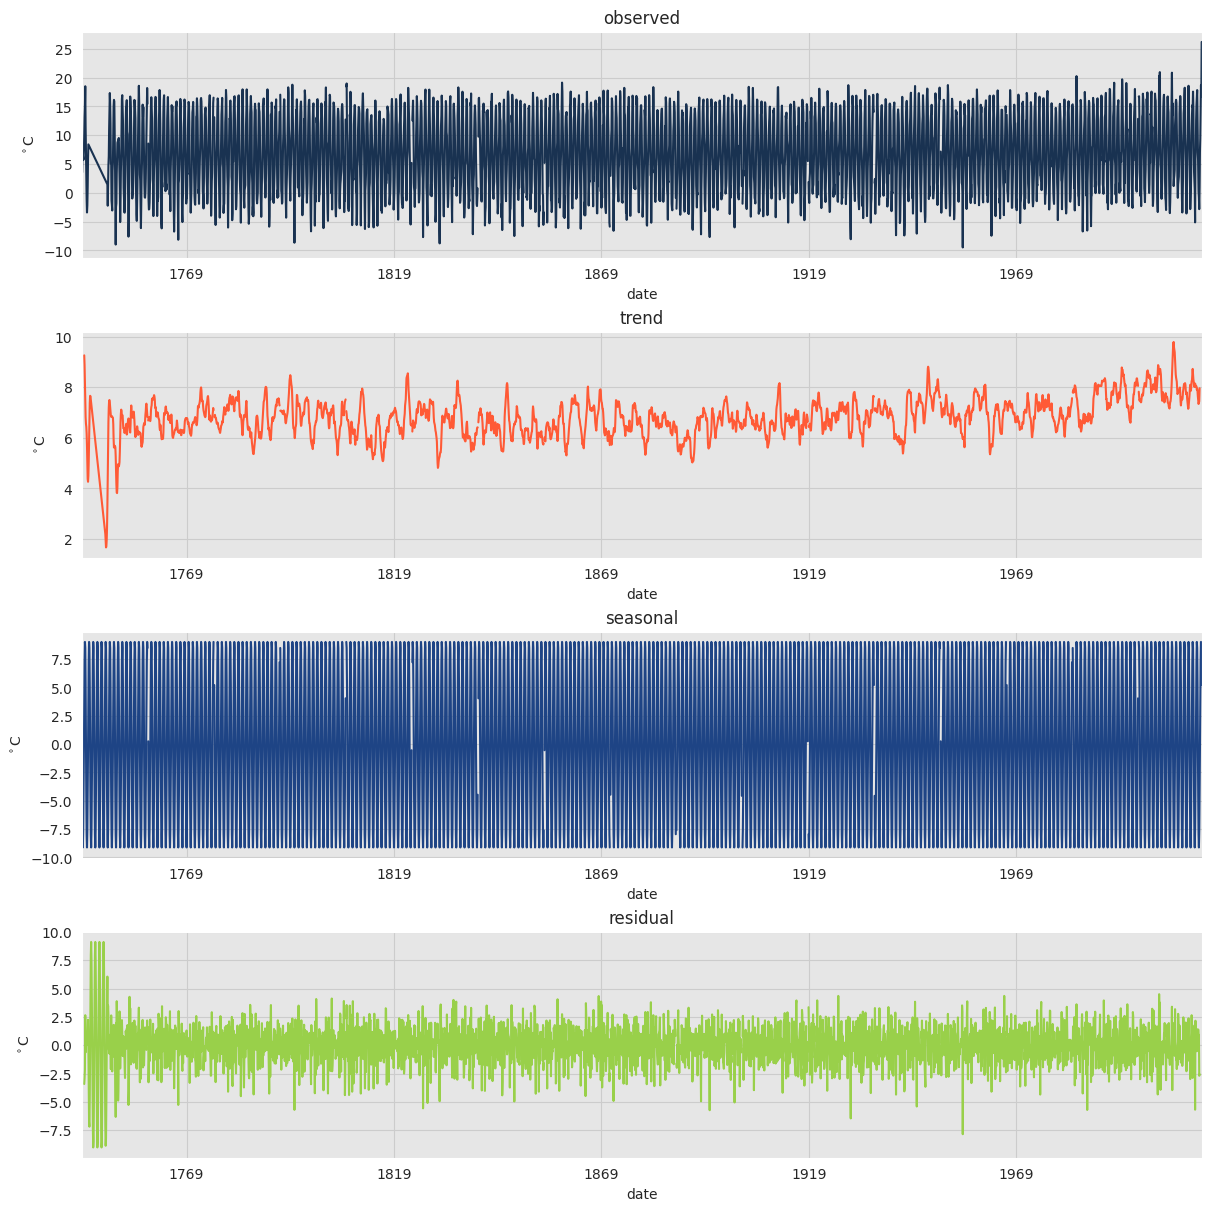

In [181]:
def trend_season_residual(df, plot=False):
    # We use the parameter `period` = 12 to extract the yearly seasonality. 
    seas_decomp_yearly = seasonal_decompose(
        x=df, 
        model='additive', 
        period=12
    )
    
    if plot:
        # Plot data
        fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

        seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
        ax[0].set(title='observed', ylabel=r'$^\circ$C')
        seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
        ax[1].set(title='trend', ylabel=r'$^\circ$C')
        seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
        ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
        seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
        ax[3].set(title='residual', ylabel=r'$^\circ$C');
    return seas_decomp_yearly

#ds = make_series(df, 'AverageTemperature', 'Zurich')
#seas_decomb_yearly = trend_season_residual(ds, True)

In [75]:
# Test for stationarity 

def stationarity_test(df, significance_level):
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = df.rolling(12).mean()
    rolling_std_dev = df.rolling(12).std()
    
    # Plot the statistics
    plt.figure(figsize=(9,3))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(df, color='#99D04A',label='Original Time Series')
    #plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    df = df.dropna()
    print('ADF Test:')
    adf_test = adfuller(df,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))
    if adf_test[1]<significance_level:# abs(adf_test[0]) > abs(adf_test[4][significance_level+"%"]) 
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")
    print('----'*10)
    
    # KPSS test
    print('KPSS Test:')
    kpss_test = kpss(df, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Critical Values:")
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    if kpss_test[1]<significance_level:# or abs(kpss_test[0]) < abs(kpss_test[3]["5%"]):
        print("Reject H0 - Time Series is Non-Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Stationary")
    print('----'*10)
    
#stationarity_test(ds, significance_level=0.01)

In [79]:
# From Kaggle.com
# https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

def tsplot(df, lags=None, figsize=(12, 7), style='bmh'):

    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        df - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        df.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(df)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(df, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(df, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#tsplot(ds)


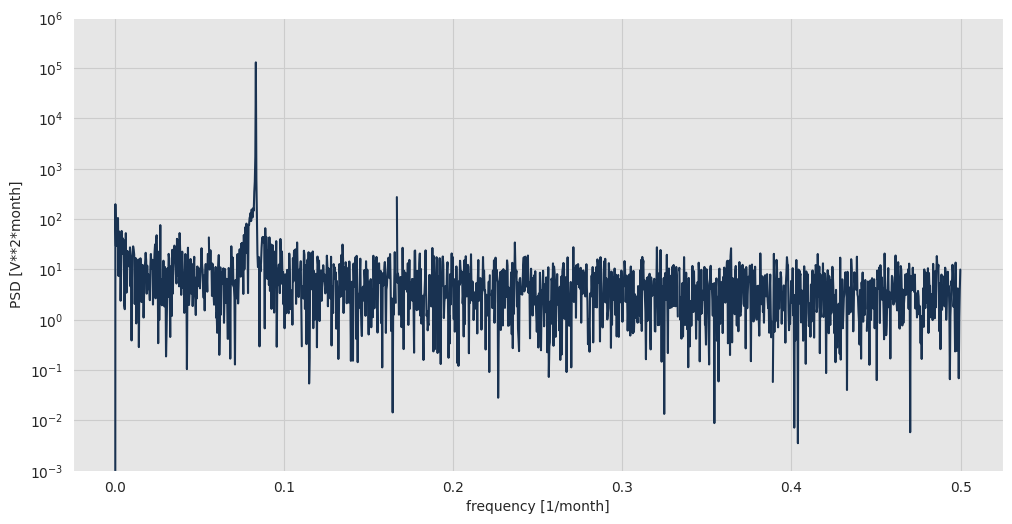

In [182]:
def plot_periodes(df):
    f, Pxx_den = signal.periodogram(df)

    plt.semilogy(f, Pxx_den)
    plt.ylim([1e-3, 1e6])
    plt.xlabel('frequency [1/month]')
    plt.ylabel('PSD [V**2*month]')
    plt.show()

#plot_periodes(ds)

In [ ]:
'''# De-trending the time series
df['Temperature_Detrend'] = (df['AverageTemperature'] - df['AverageTemperature'].shift(12))
stationarity_test(df, 'Temperature_Detrend', 'Zurich', significance_level=0.01)'''

In [183]:
# Split data into train and test set
def ds_split(ds, ratio=0.8):
    train_test_split_ratio = int(len(ds)*ratio)
    train_data, test_data = ds[:train_test_split_ratio], ds[train_test_split_ratio:]
    return train_data, test_data

train_data, test_data = ds_split(seas_decomb_yearly.trend, 0.8)

In [ ]:
'''
df_arima = df.query("City=='Zurich'")['AverageTemperature']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]'''

'''# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('AverageTemperature')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()'''

In [ ]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

In [ ]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

In [131]:
# Auto ARIMA Method
def arima_prediction(train_data, test_data, plot=False):
  arima_model = auto_arima(train_data,
                        start_p=0,                # (AR-Part)ist die Anzahl der Lags ist, die die Signifikanzgrenze im PACF-Diagramm überschreitet.
                        max_p=4,
                        start_q=0,                # (MA-Part)ist die Anzahl der Lags ist, die die Signifikanzgrenze im ACF-Diagramm überschreitet.
                        max_q=8, 
                        d=0,                      # Differenciation for becomming stational in non-seasonal; Tests with ADF, KPSS, PP or by eye (MA)
                        #D=1,                      # Differenciation for becomming stational in seasonal; !!! D<0 1 und D+d <=2 !!! 
                        #m=1,                     # Frequency, e.g. m=12 lines
                        max_d=5,
                        
                        #start_P=0,
                        #max_P=5,
                        #start_Q=12,
                        #max_Q=12,
                        seasonal = True,
                        error_action='warn',
                        trace=True,
                        suppress_warnings=True,
                        stewise=True,
                        #random_state=20,
                        #fits=50,
                        test='adf',        
                        #alpha=0.05,               # $\alpha$ is the intercept term of AR-Part
                        scoring='mse',
                          )

  # Fit the final model with the order
  fitted_model = arima_model.fit(train_data) 
  print(fitted_model.summary())

  # Forecasting values
  forecast_values = fitted_model.predict(len(test_data), index=test_data.index, return_conf_int=True) #, alpha=0.05) 
  fcv_series = pd.Series(forecast_values[0], index=test_data.index)
  if plot:
    # Plot the predicted stock price and original price
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_data, label='training', color='black')
    plt.plot(test_data, label='Measured Average Temperature')
    plt.plot(fcv_series,label='Predicted Average Temperature')
    plt.xlim([pd.to_datetime("1900-01-01"), pd.to_datetime("2013-09-01")])
    plt.title('Average Temperature Prediction')
    plt.xlabel('Time')
    plt.ylabel('Average Temperature')
    #plt.xticks([])
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

  # Evaluate the model by calculating RMSE
  rms_auto_arima = sqrt(mean_squared_error(test_data.dropna().values, fcv_series))
  print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))
  return fcv_series

In [56]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  6.888
Simple Exponential Smoothing:  6.73
Holt’s Exponential Smoothing:  9.862


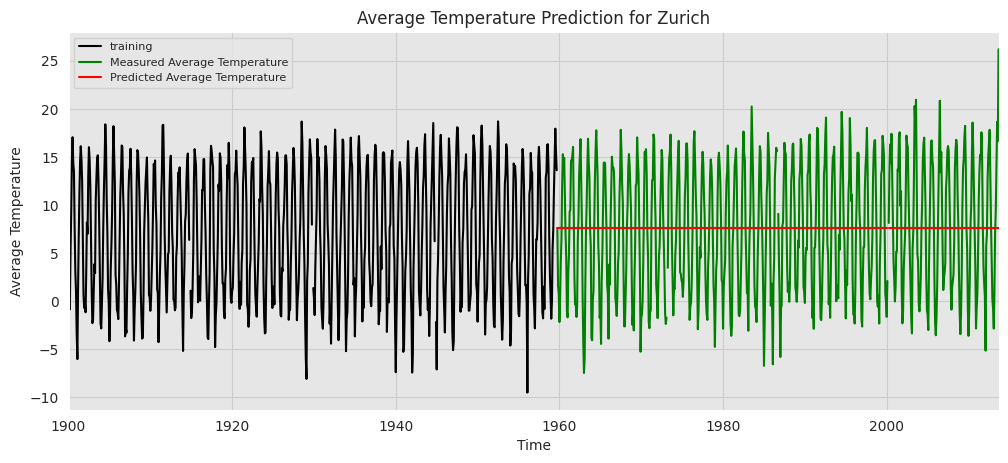

In [11]:
city = 'Zurich'
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training', color='black')
plt.plot(test_data, label='Measured Average Temperature', color="green")
plt.plot(fcv_series,label='Predicted Average Temperature', color="red")
plt.xlim([pd.to_datetime("1900-01-01"), pd.to_datetime("2013-09-01")])
plt.title('Average Temperature Prediction for ' + city)
plt.xlabel('Time')
plt.ylabel('Average Temperature')
#plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()


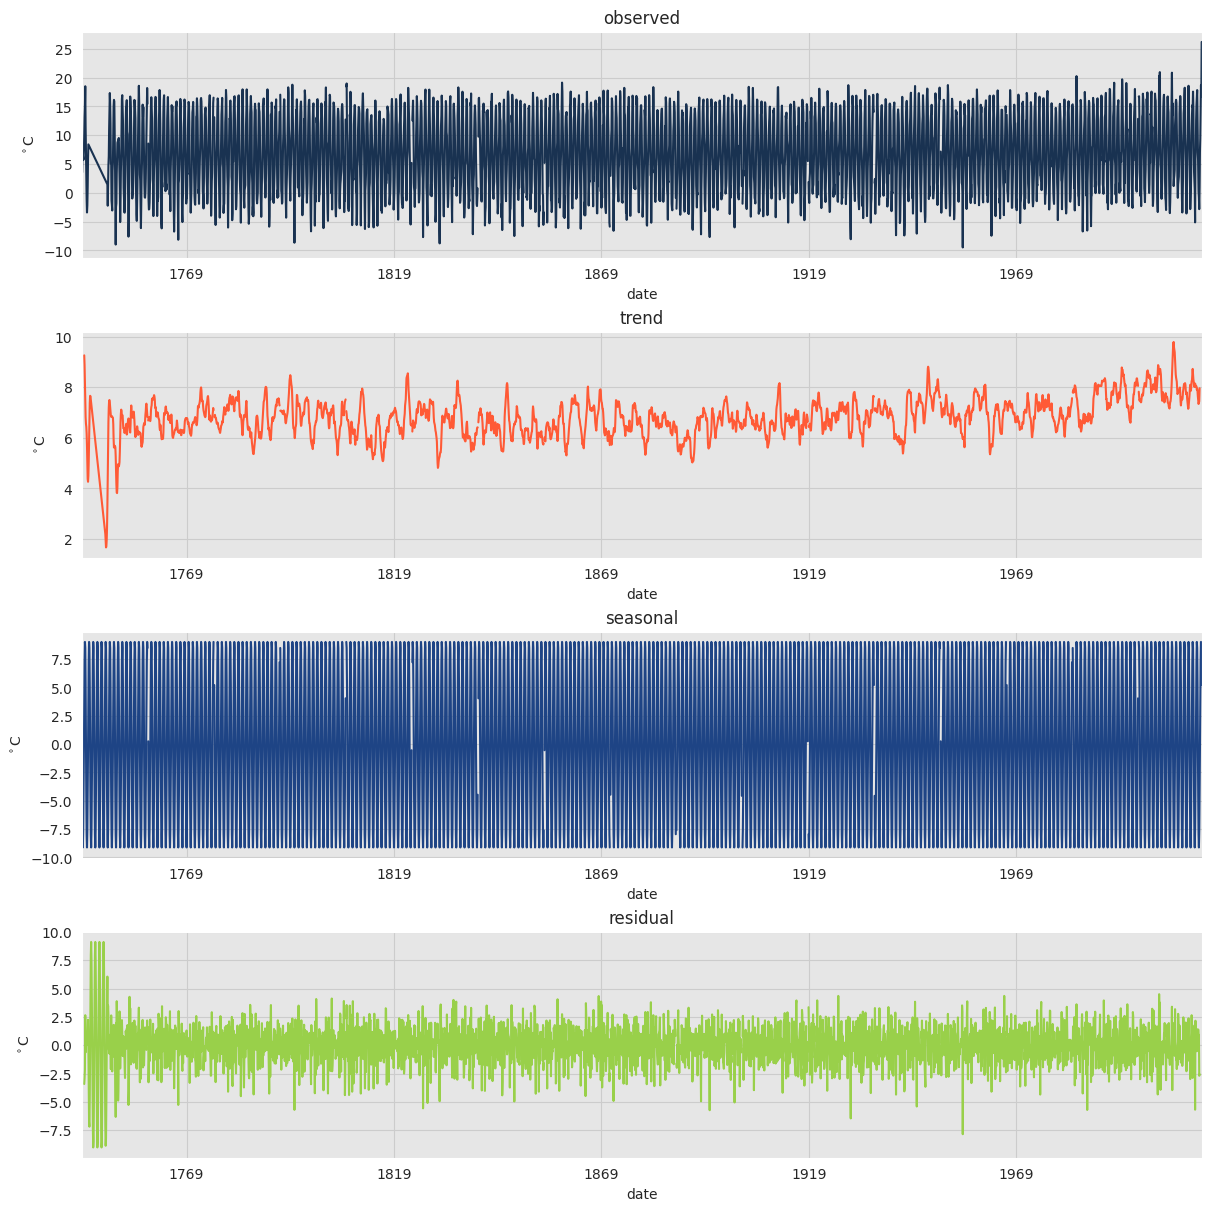

In [76]:
ds = make_series(df, 'AverageTemperature', 'Zurich')
seas_decomb_yearly = trend_season_residual(ds)

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -5.479699
p-value: 0.000002
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 3.016809
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Failed to Reject H0 - Time Series is Stationary
----------------------------------------


/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


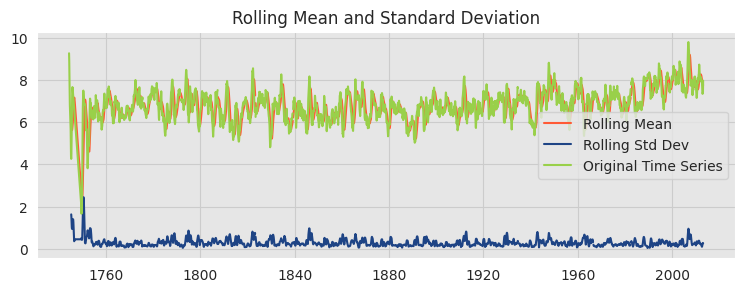

In [77]:
stationarity_test(seas_decomb_yearly.trend, significance_level=0.01)

/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


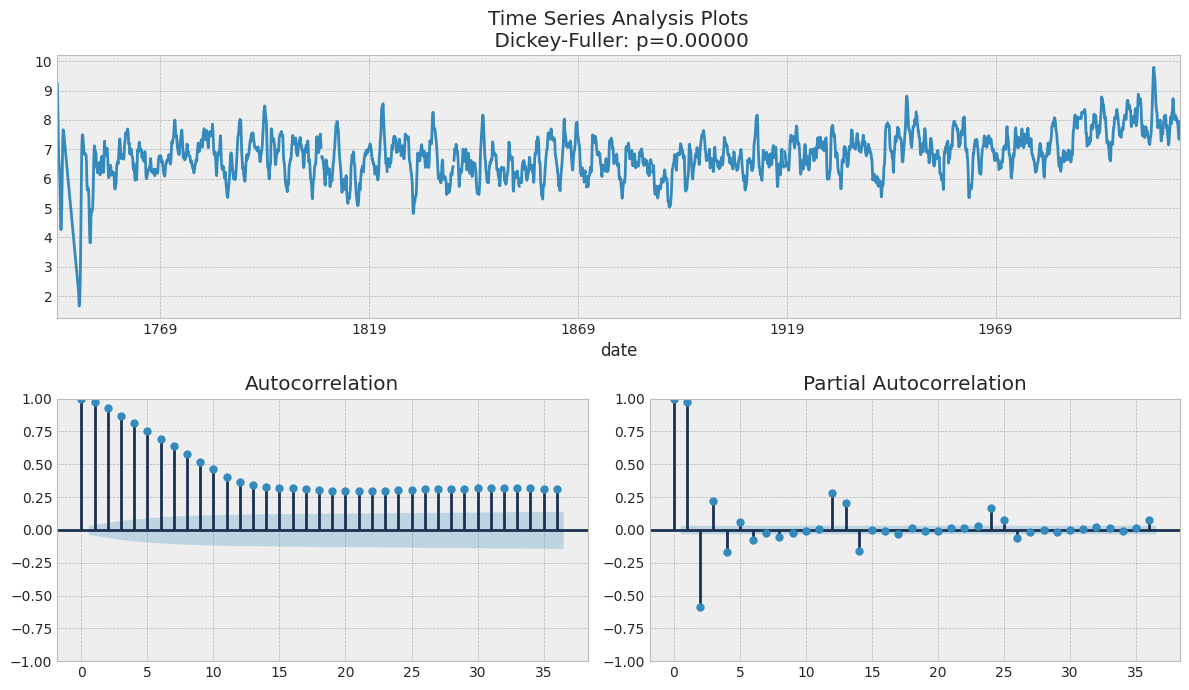

In [119]:
tsplot(seas_decomb_yearly.trend.dropna())

In [184]:
train_data, test_data = ds_split(seas_decomb_yearly.trend, 0.95)
arima_prediction(train_data, test_data)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6926.590, Time=1.90 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2429.013, Time=4.85 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=12.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20468.346, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4096.364, Time=6.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-4411.800, Time=17.85 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-4687.290, Time=14.32 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=40.82 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=23.74 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=8.36 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 131.205 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3077
Model:               SARIMAX(4, 0, 0)   Log Likelihood                

ValueError: Found input variables with inconsistent numbers of samples: [156, 162]

In [168]:
city_list = df.City.unique()
ds = make_series(df, 'AverageTemperature', city_list[0])
seas_decomb_yearly = trend_season_residual(ds)
trend_mean = seas_decomb_yearly.trend[6:-6]
z = 0
for i in tqdm(city_list[1:73]):
    ds = make_series(df, 'AverageTemperature', i)
    seas_decomb_yearly = trend_season_residual(ds)
    if seas_decomb_yearly.trend[6:-6].isnull().sum() == 0:
        trend_mean += seas_decomb_yearly.trend[6:-6]
        z += 1

df["trend_mean"] = trend_mean/z

100%|██████████| 72/72 [00:54<00:00,  1.31it/s]


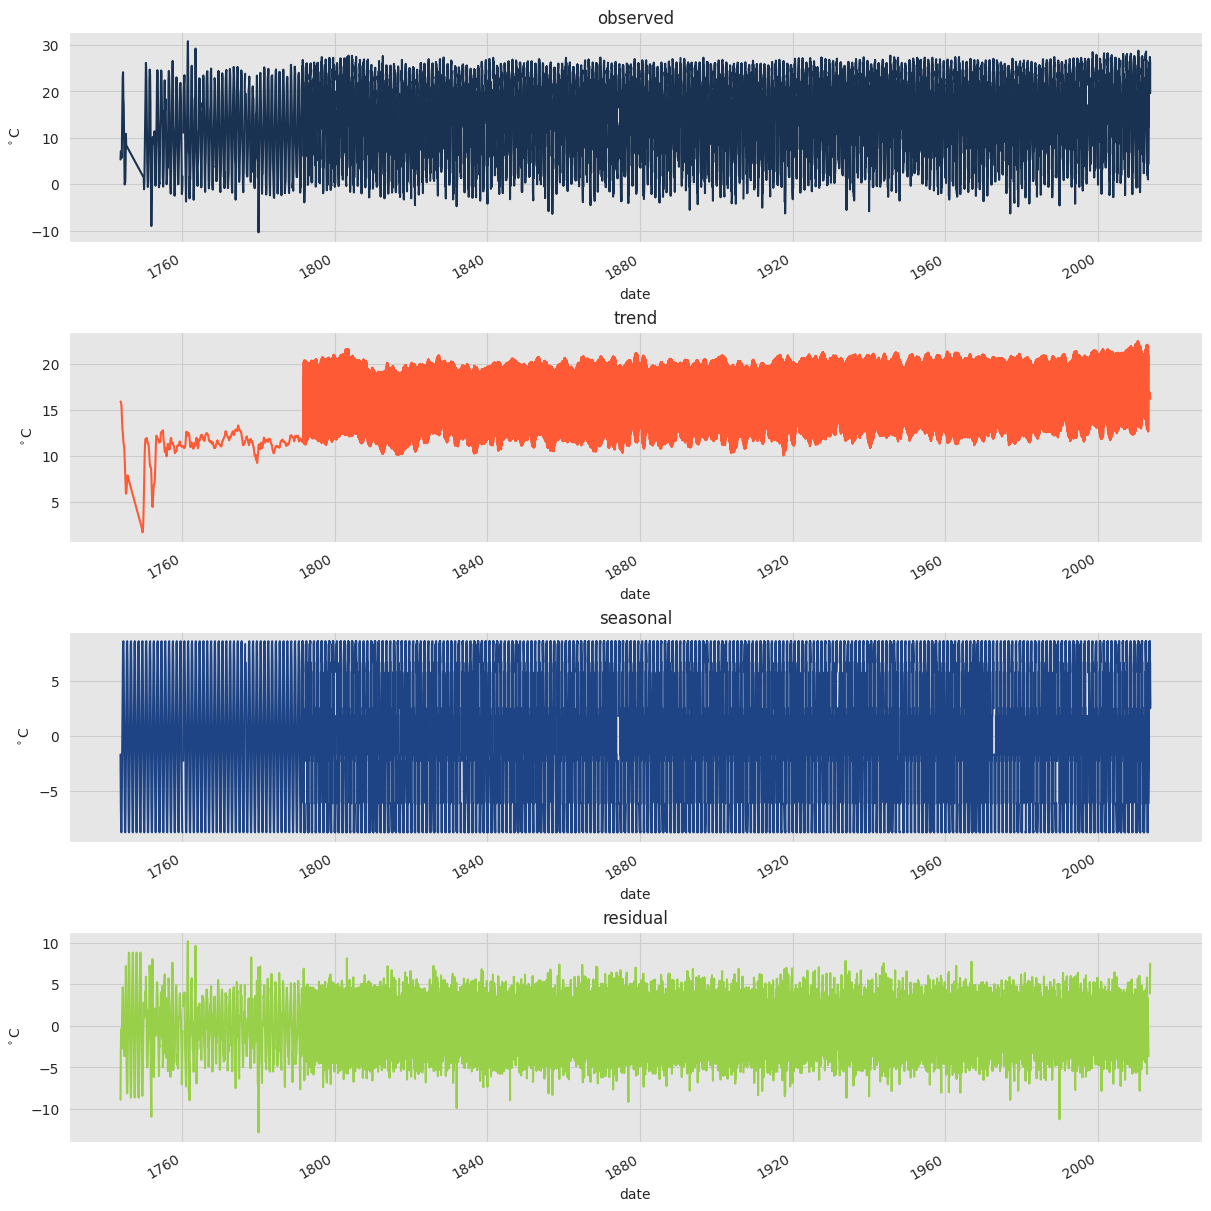

In [165]:
ds = make_series(df, 'AverageTemperature', city_list[75])
seas_decomb_yearly = trend_season_residual(ds, plot=True)

In [166]:
seas_decomb_yearly.trend[6:-6].isnull().sum()

0

In [167]:
trend_mean

date
1744-05-01            NaN
1744-06-01            NaN
1744-07-01            NaN
1744-08-01            NaN
1744-09-01            NaN
                 ...     
2012-11-01    1436.901042
2012-12-01    1433.674292
2013-01-01    1430.789042
2013-02-01    1429.035667
2013-03-01    1436.942417
Name: trend, Length: 3227, dtype: float64

In [173]:
df.isnull().sum()

dt                                     0
AverageTemperature                     0
AverageTemperatureUncertainty     364130
City                                   0
Country                                0
Latitude                               0
Longitude                              0
year                                   0
month                                  0
day                                    0
dayofyear                              0
trend_mean                       2840565
dtype: int64